In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import scipy.sparse as sp
import yaml
import time
import gget
from scipy.stats import zscore

import anndata as an
import scanpy as sc
import rapids_singlecell as rsc
import scvi
from matplotlib.colors import LinearSegmentedColormap

import cupy as cp
from cuml.manifold import TSNE
from cuml.decomposition import PCA

sc.settings.verbosity = 2

# Load in data

In [2]:
%%time
fpath = "/scratch/indikar_root/indikar1/shared_data/hematokytos/new_processed/fib_ihsc_processed.h5ad"
adata = sc.read_h5ad(fpath)
adata.X = adata.layers['log_norm'].copy()
adata

CPU times: user 429 ms, sys: 1.52 s, total: 1.95 s
Wall time: 48.4 s


AnnData object with n_obs × n_vars = 15317 × 23434
    obs: 'batch', 'barcoded_phase', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'S_score', 'G2M_score', 'phase', 'leiden', 'cluster_str', 'cluster'
    var: 'gene_id', 'gene_type', 'Chromosome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'highly_variable_rank', 'variances', 'variances_norm'
    uns: 'batch_colors', 'cluster_colors', 'dr

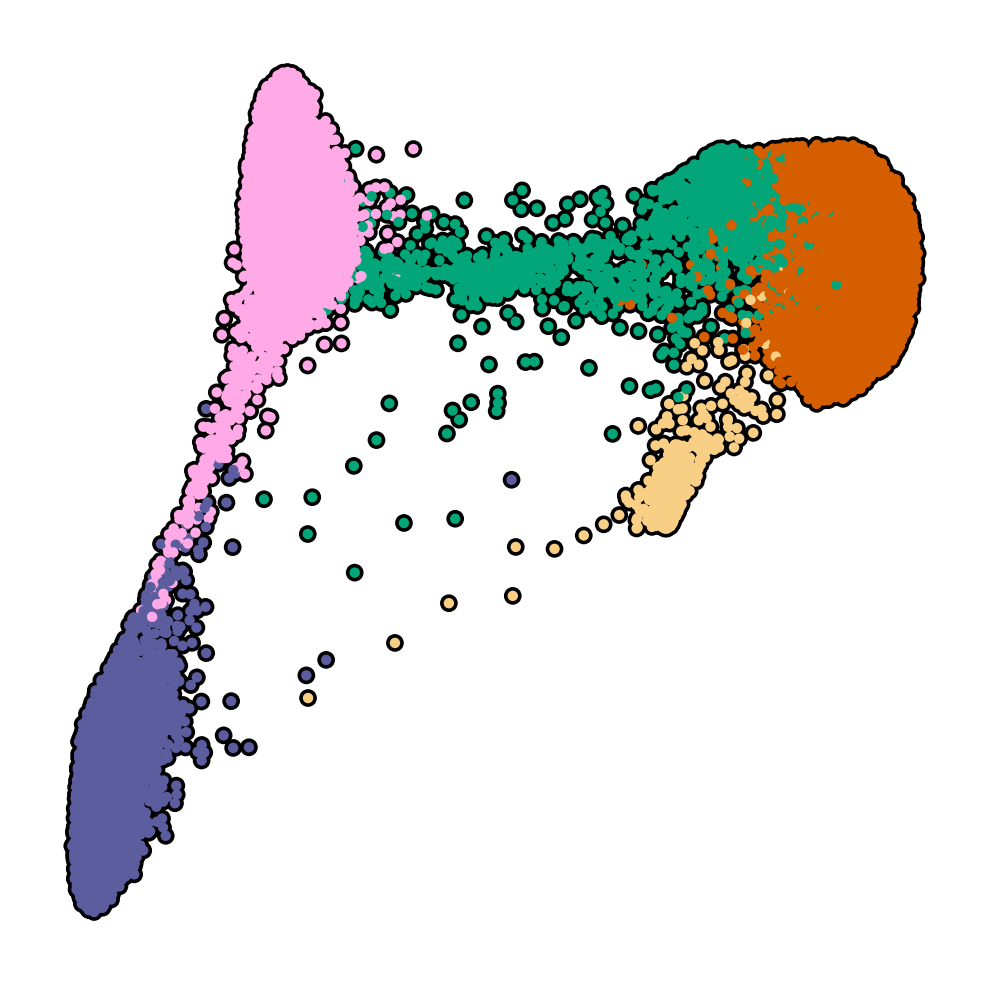

In [3]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 4

sc.pl.draw_graph(
    adata,
    color=['cluster'],
    size=25,
    ncols=1,
    add_outline=True,
    outline_color=('k', 'k'),
    frameon=False,
    alpha=1,
    title='',
    legend_loc='none',
)

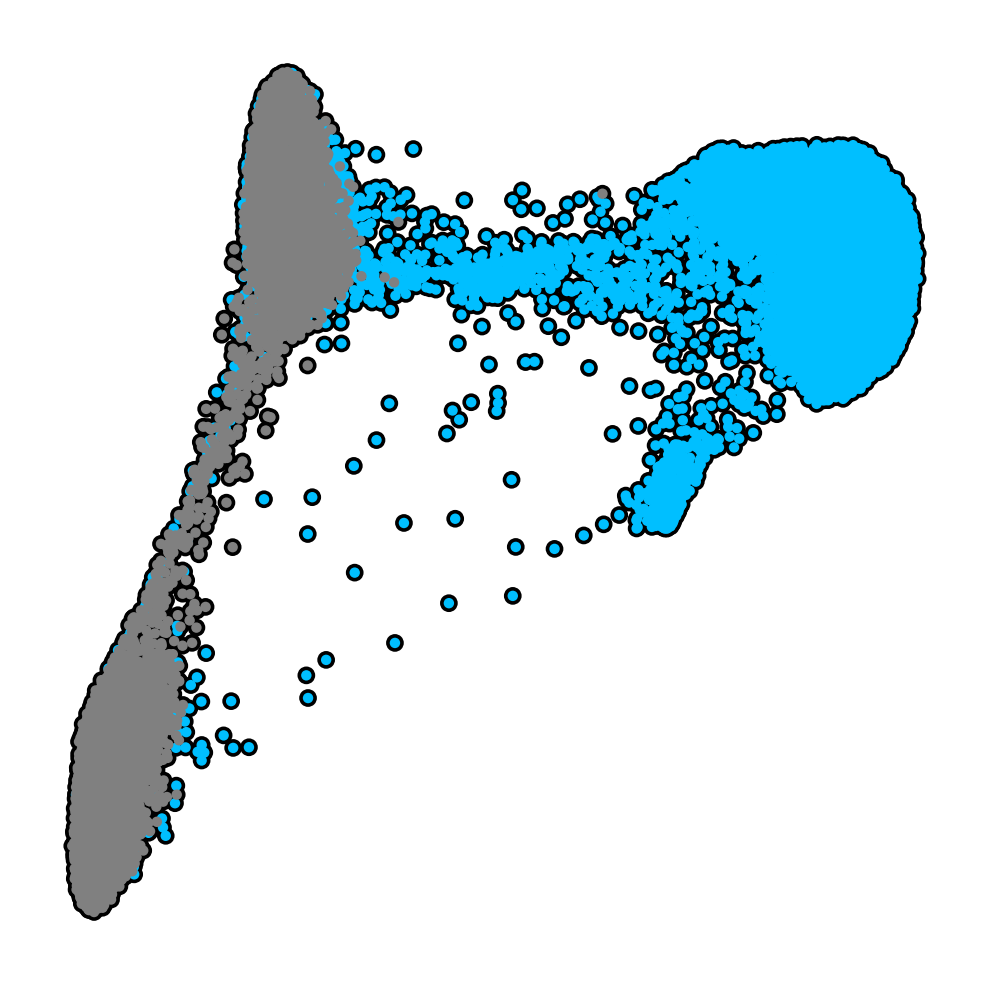

In [4]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 4

sc.pl.draw_graph(
    adata,
    color=['batch'],
    size=25,
    ncols=1,
    add_outline=True,
    outline_color=('k', 'k'),
    frameon=False,
    alpha=1,
    title='',
    legend_loc='none',
    palette=['Grey', 'deepskyblue'],
)

  batch  count
0   hsc   8357
1   fib   6960


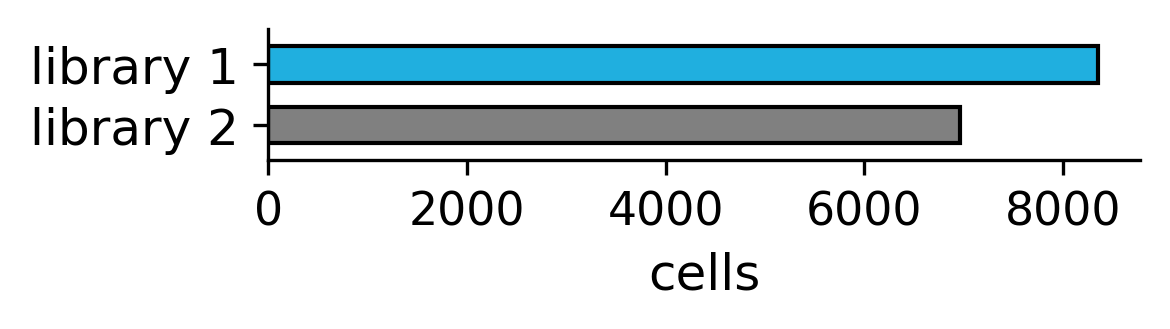

In [15]:
# Prepare data and sort by count descending
batch_counts = adata.obs['batch'].value_counts().reset_index()
batch_counts.columns = ['batch', 'count']
batch_counts = batch_counts.reset_index(drop=True)

print(batch_counts)

# Transposed horizontal barplot with largest bar on top
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 1.2

sns.barplot(
    data=batch_counts,
    y='batch',
    x='count',
    ec='k',
    hue='batch',
    legend=False,
    width=0.6,
    palette=['Grey', 'deepskyblue']  # first = largest
)

plt.gca().invert_yaxis()

plt.ylabel("")
plt.xlabel("cells", fontsize=12)
plt.xticks(fontsize=11)

# Custom y-axis labels, assuming batch_counts['batch'] has the correct order
plt.gca().set_yticklabels(['library 2', 'library 1'], fontsize=12)
plt.margins(y=0.18)

sns.despine()
plt.tight_layout()
plt.show()

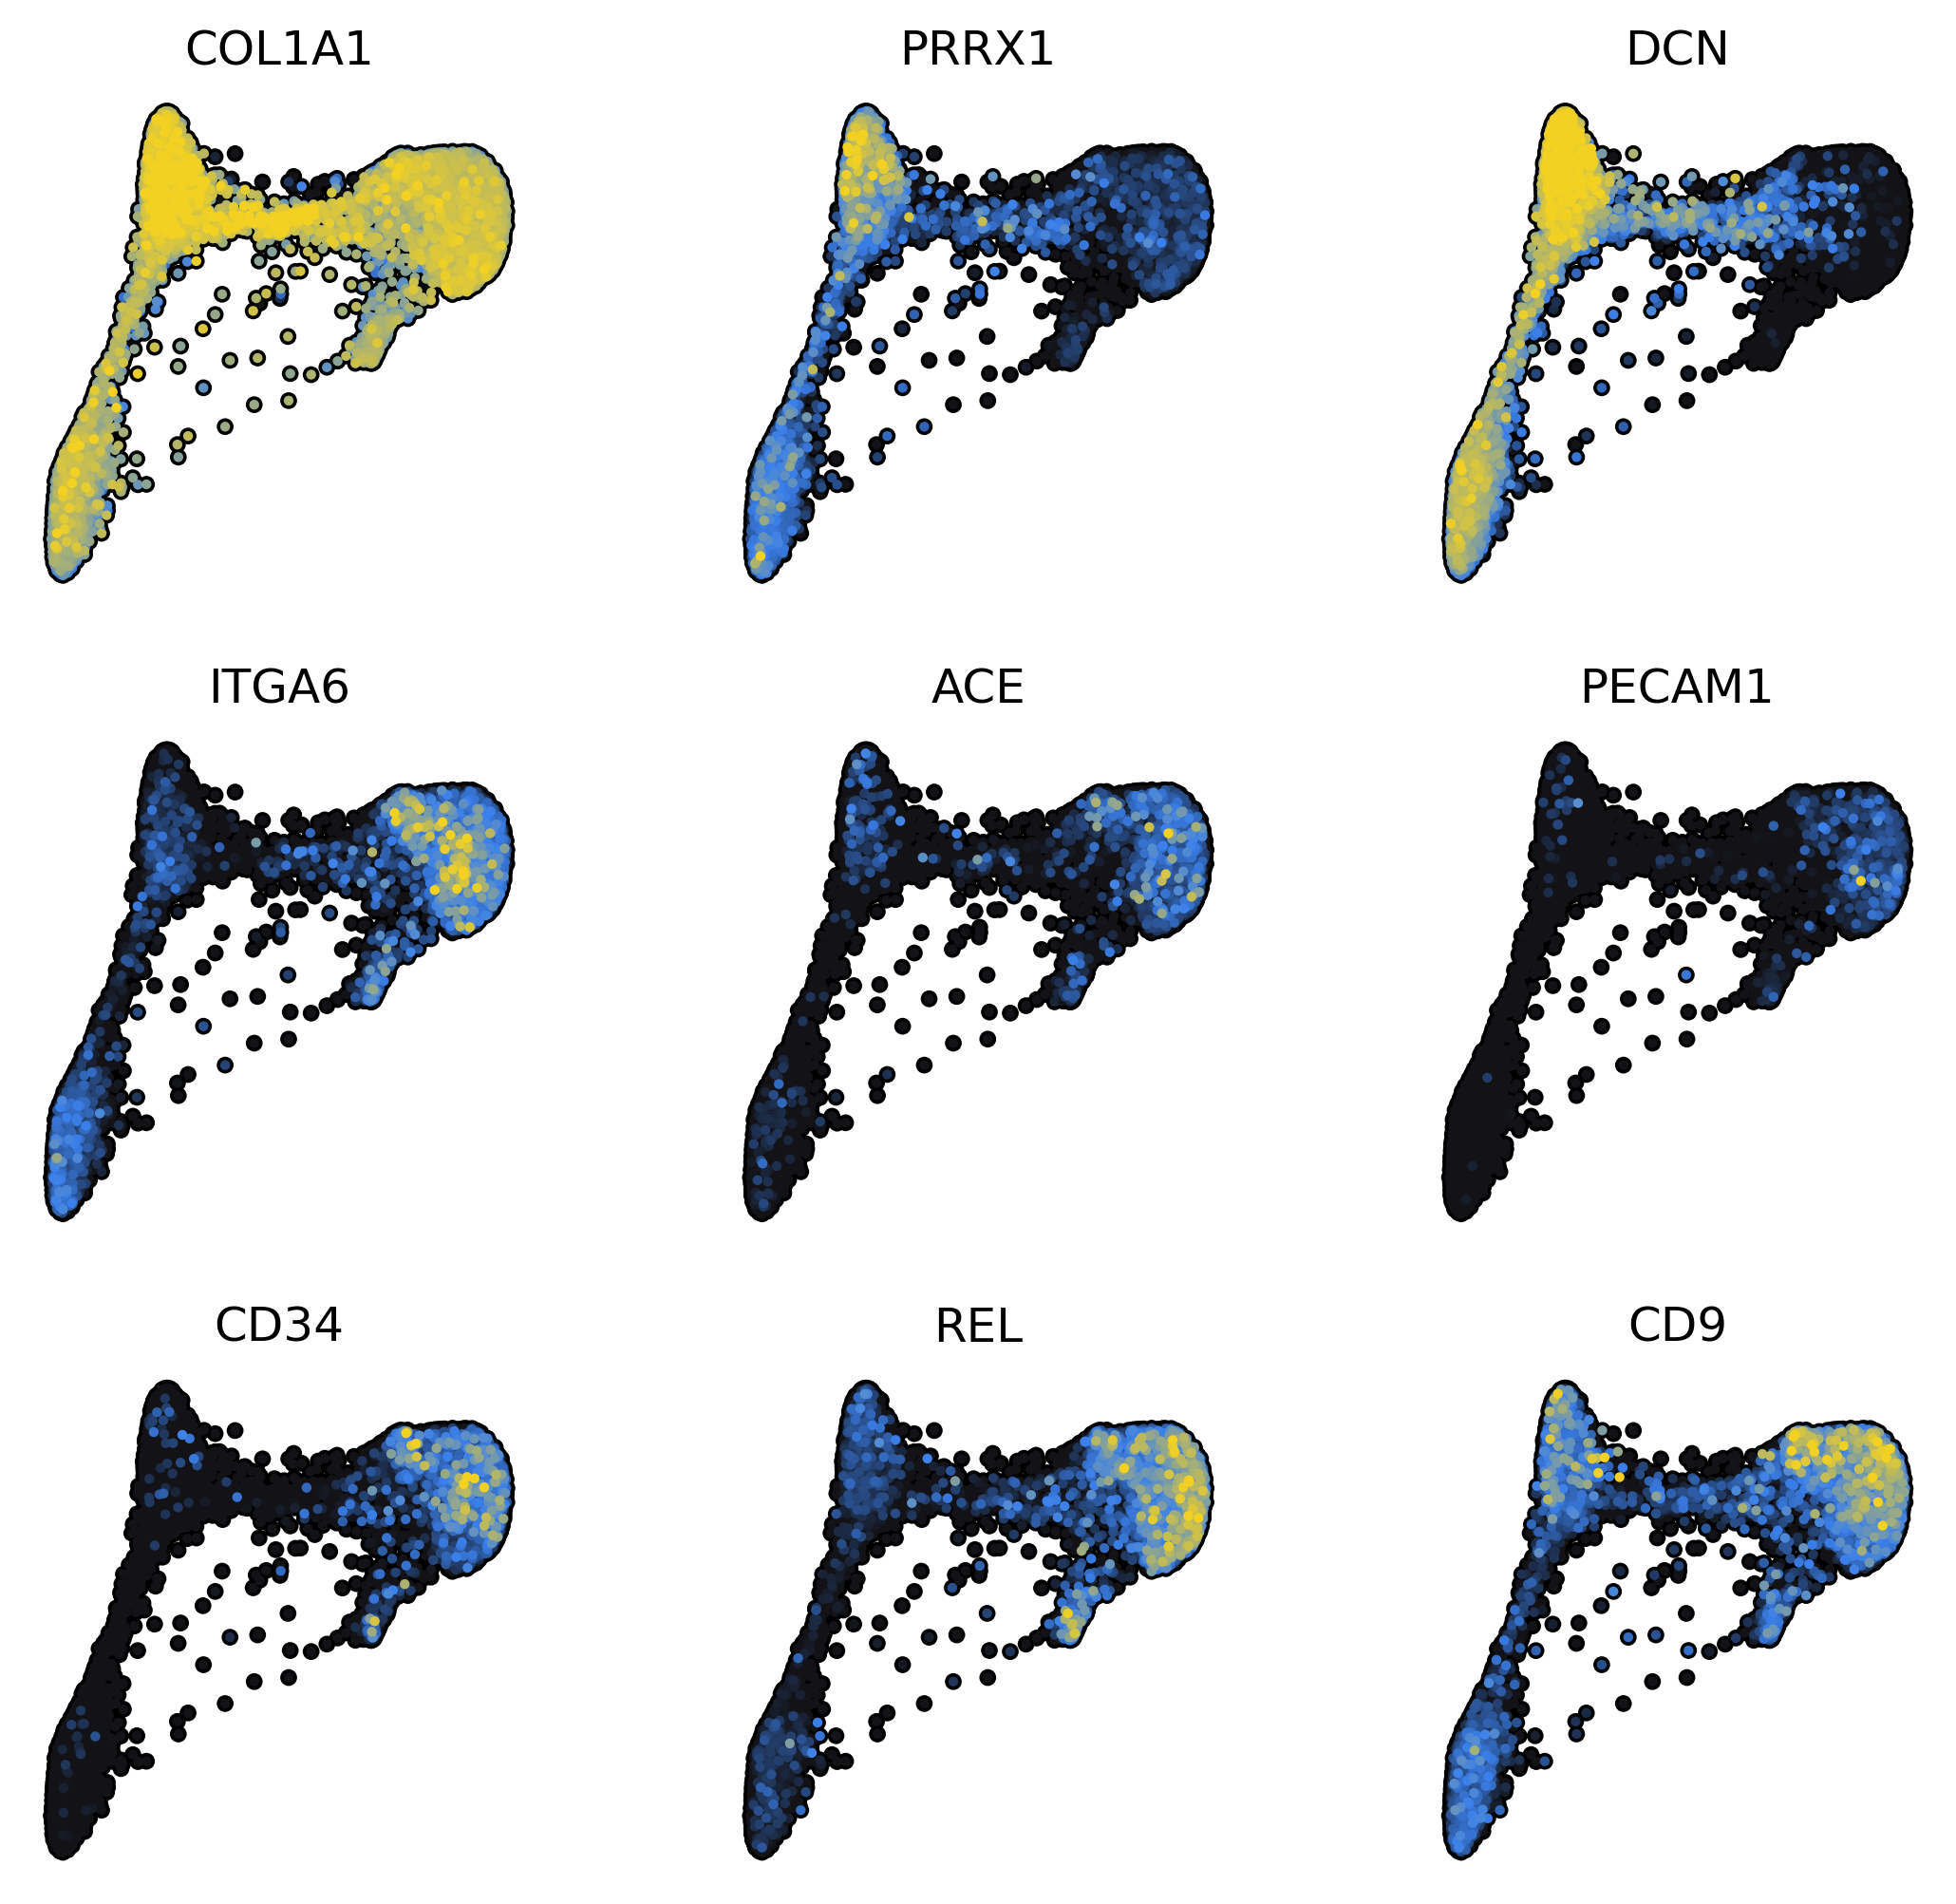

In [23]:
low = '#131317' # dark
mid = '#3B80EB' # blue
high = '#F2D123' # yellow

custom_cmap = LinearSegmentedColormap.from_list(
    "custom_cmap",
    [(0.0, low), (0.15, low), (0.5, mid), (0.85, high), (1.0, high)]
)



genes_to_plot = [
    'COL1A1', 'PRRX1', 'DCN',
    'ITGA6', 'ACE', 'PECAM1', 
    'CD34', 'REL', 'CD9',#'SPINK2',
]

genes_to_plot = [g for g in genes_to_plot if g in adata.var_names]

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 2, 2.5

sc.pl.draw_graph(
    adata,
    color=genes_to_plot,
    size=25,
    ncols=3,
    add_outline=True,
    cmap=custom_cmap,
    outline_color=('k', 'k'),
    frameon=False,
    alpha=1,
    colorbar_loc=None,
    use_raw=False,
    layer='log_norm',
    # legend_loc='none',
)

# Percent expressing (markers)

                        STAT5A  REL  FOS  GATA2  CD34  ETS2  MSI2  RUNX2  ACE  PECAM1  MECOM  ETV6   DCN   LUM   FTL  COL1A1 cluster_str batch  STAT5A+   REL+   FOS+  GATA2+  CD34+  ETS2+  MSI2+  RUNX2+   ACE+  PECAM1+  MECOM+  ETV6+  DCN+  LUM+  FTL+  COL1A1+
TGTGGTCAGTGAGCCT-1_fib     0.0  0.0  3.0    0.0   0.0   0.0   0.0    0.0  0.0     0.0    0.0   0.0  27.0  27.0  30.0    31.0          C4   fib    False  False   True   False  False  False  False   False  False    False   False  False  True  True  True     True
TGTGGTTGTAGCCCTA-1_fib     0.0  1.0  4.0    1.0   0.0   0.0   0.0    0.0  0.0     0.0    0.0   0.0  10.0   7.0  96.0    55.0          C4   fib    False   True   True    True  False  False  False   False  False    False   False  False  True  True  True     True
TGTGGTTGTTGAAGGC-1_fib     0.0  0.0  0.0    0.0   0.0   0.0   0.0    0.0  0.0     0.0    0.0   0.0  19.0  13.0  79.0    91.0          C4   fib    False  False  False   False  False  False  False   False  False    Fals

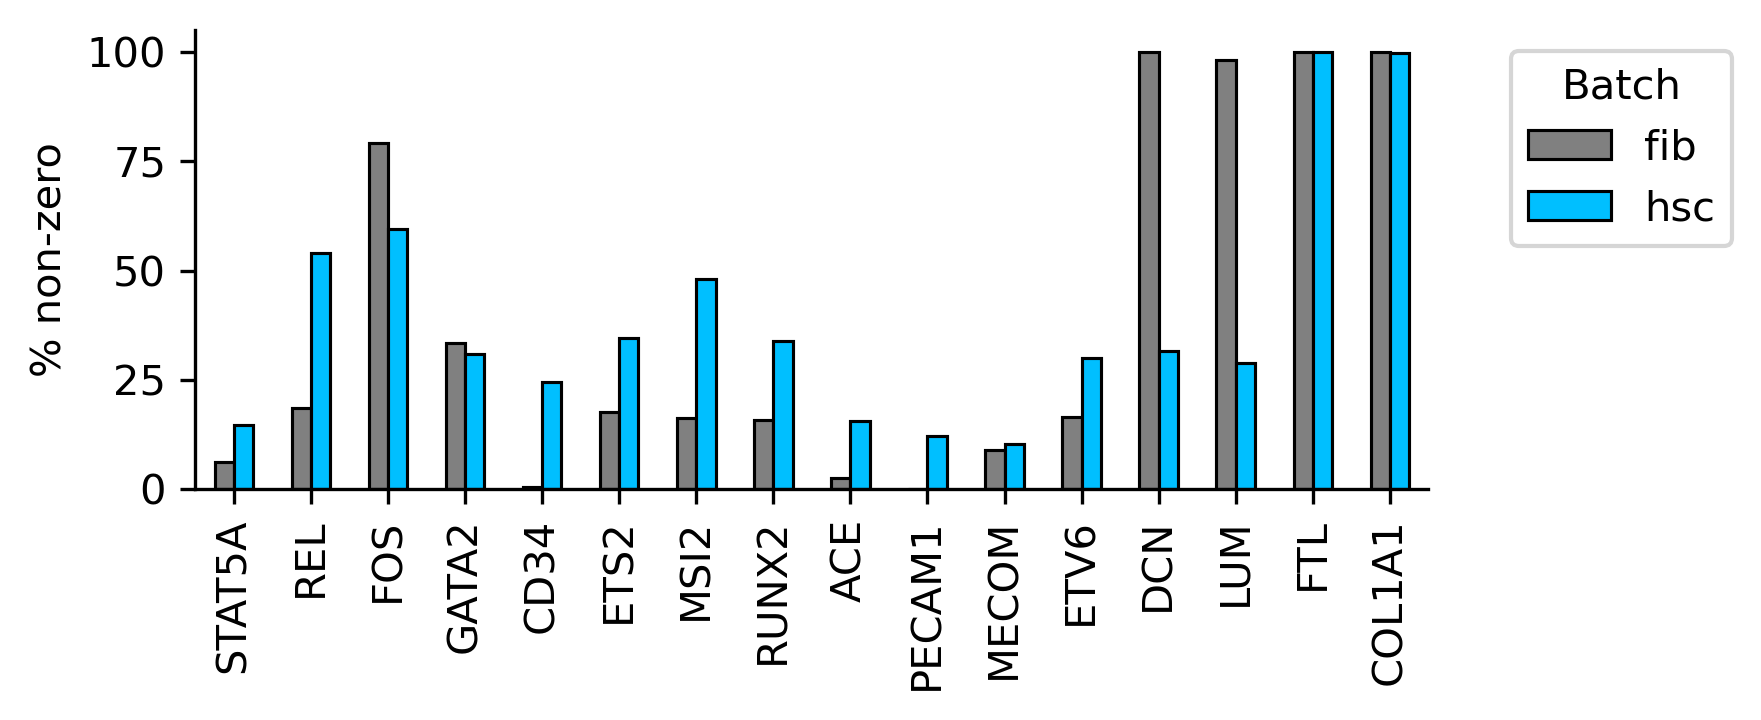

In [18]:
query  = [
    'STAT5A',
    'REL',
    'FOS',
    'GATA2',
    'CD34',
    # 'PROCR',
    'ETS2',
    # 'HHEX',
    'MSI2',
    'RUNX2',
    'ACE',
    'PECAM1',
    'MECOM', 
    'ETV6',
    'DCN',
    'LUM',
    'FTL',
    'COL1A1',
]

query = [g for g in query if g in adata.var_names]
pdf = adata[:, query].to_df(layer='raw_counts')
pdf['cluster_str'] = adata.obs['cluster_str']
pdf['batch'] = adata.obs['batch']

for q in query:
    pdf[f'{q}+'] = pdf[q] > 0

print(pdf.tail().to_string())

# Step 3: Calculate % q+ by gene and batch
plot_df = (
    pdf.groupby('batch', observed=True)[[f'{q}+' for q in query]]
    .mean()
    .T * 100  # Convert to percent
)

plot_df.index = [gene.replace('+', '') for gene in plot_df.index]  # Clean labels

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 2.5#2.75

# Step 4: Plot stacked bar chart
plot_df.plot(
    kind='bar',
    ec='k',
    lw=0.75,
    color=['Grey', 'deepskyblue'],
)
plt.ylabel('% non-zero')
plt.legend(title='Batch', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
sns.despine()

plt.gcf().patch.set_facecolor('none')  # Transparent outer figure background
plt.gca().set_facecolor('none')         # Transparent axes (plot area) background
plt.show()